In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os.path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
plot_predictions = False

data_path = 'data'
categories = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

data = []
labels = []

In [5]:
for category in categories:
    category_path = os.path.join(data_path, category)
    class_num = categories.index(category)
    for img in os.listdir(category_path):
        try:
            img_path = os.path.join(category_path, img)
            img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            data.append(img_array)
            labels.append(class_num)
        except Exception as e:
            pass

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(16*16, 26)

    def forward(self, x):
        x = x.view(-1, 16*16)
        x = self.fc1(x)
        return x

In [7]:
def load_model():
    model = Net()
    if os.path.isfile('model.pth'):
        model.load_state_dict(torch.load('model.pth'))
        return model, True

    return model, False

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

Epoch 1/100 - Loss: 3.1497383365091287 - Accuracy: 0.07547169811320754
Correct predictions: 8 - Total predictions: 106
Epoch 2/100 - Loss: 2.6154219255132496 - Accuracy: 0.20754716981132076
Correct predictions: 22 - Total predictions: 106
Epoch 3/100 - Loss: 2.224815573613599 - Accuracy: 0.33962264150943394
Correct predictions: 36 - Total predictions: 106
Epoch 4/100 - Loss: 1.924740305908446 - Accuracy: 0.5
Correct predictions: 53 - Total predictions: 106
Epoch 5/100 - Loss: 1.688793014524118 - Accuracy: 0.5754716981132075
Correct predictions: 61 - Total predictions: 106
Epoch 6/100 - Loss: 1.4980845682604134 - Accuracy: 0.6509433962264151
Correct predictions: 69 - Total predictions: 106
Epoch 7/100 - Loss: 1.340441051659719 - Accuracy: 0.6981132075471698
Correct predictions: 74 - Total predictions: 106
Epoch 8/100 - Loss: 1.2076369741017807 - Accuracy: 0.7358490566037735
Correct predictions: 78 - Total predictions: 106
Epoch 9/100 - Loss: 1.0938434660399579 - Accuracy: 0.783018867924

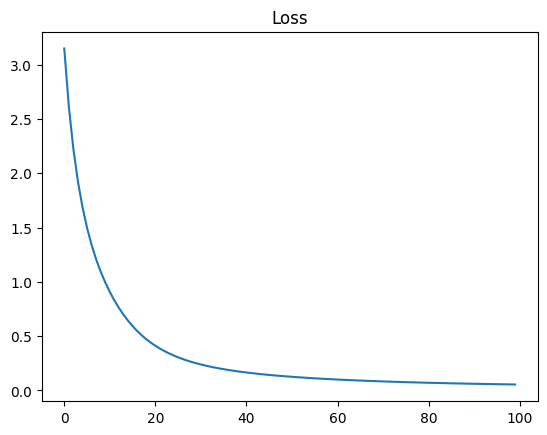

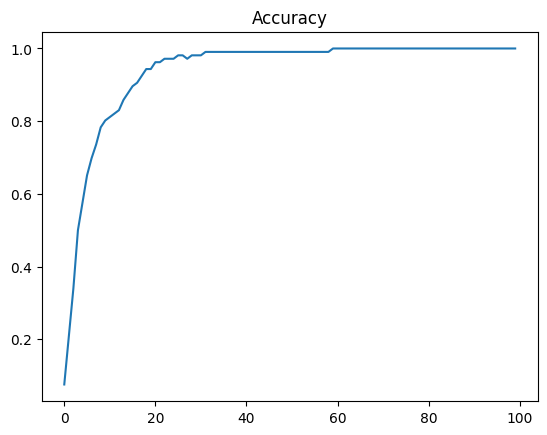

In [9]:
import matplotlib.pyplot as plt

save_model_to_file = False
plot_predictions = True
epochs = 100
learning_rate = 0.001

model, loaded = load_model()

if not loaded:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    loss_values = []
    accuracy_values = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for i in range(len(X_train)):
            img = X_train[i]
            label = y_train[i]

            img = cv2.resize(img, (16, 16))
            img = img / 255.0
            img = np.expand_dims(img, axis=0)
            img = np.expand_dims(img, axis=0)
            img = torch.from_numpy(img).float()

            optimizer.zero_grad()

            outputs = model(img)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == label).sum().item()
            total_predictions += 1

            loss = criterion(outputs, torch.tensor([label]))

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(X_train)
        epoch_accuracy = correct_predictions / total_predictions

        loss_values.append(epoch_loss)
        accuracy_values.append(epoch_accuracy)

        print(f'Epoch {epoch + 1}/{epochs} - Loss: {epoch_loss} - Accuracy: {epoch_accuracy}')
        print(f'Correct predictions: {correct_predictions} - Total predictions: {total_predictions}')

    if save_model_to_file:
        torch.save(model.state_dict(), 'model.pth')

    if plot_predictions:
        plt.plot(loss_values)
        plt.title('Loss')
        plt.show()

        plt.plot(accuracy_values)
        plt.title('Accuracy')
        plt.show()

In [10]:
total_predictions = 0
correct_predictions = 0

for i in range(len(X_test)):
    img = X_test[i]
    label = y_test[i]

    img = cv2.resize(img, (16, 16))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=0)
    img = torch.from_numpy(img).float()
    
    outputs = model(img)

    _, predicted = torch.max(outputs.data, 1)
    correct = 'Yes' if predicted == label else 'No'
    print(f'Predicted: {categories[predicted]} - Confidence: {round(F.softmax(outputs, dim=1).data[0][predicted].item(), 2)} - Actual: {categories[label]} - Correct: {correct}')
    correct_predictions += (predicted == label).sum().item()
    total_predictions += 1

print("\n")
print(f'Correct predictions: {correct_predictions} - Total predictions: {total_predictions}')
print(f'Accuracy: {correct_predictions / total_predictions}')


Predicted: l - Confidence: 0.35 - Actual: e - Correct: No
Predicted: a - Confidence: 1.0 - Actual: a - Correct: Yes
Predicted: c - Confidence: 0.72 - Actual: c - Correct: Yes
Predicted: k - Confidence: 0.98 - Actual: k - Correct: Yes
Predicted: b - Confidence: 0.41 - Actual: b - Correct: Yes
Predicted: a - Confidence: 0.65 - Actual: m - Correct: No
Predicted: x - Confidence: 0.54 - Actual: x - Correct: Yes
Predicted: c - Confidence: 0.3 - Actual: k - Correct: No
Predicted: b - Confidence: 0.91 - Actual: b - Correct: Yes
Predicted: s - Confidence: 0.66 - Actual: s - Correct: Yes
Predicted: c - Confidence: 0.89 - Actual: c - Correct: Yes
Predicted: o - Confidence: 0.94 - Actual: o - Correct: Yes
Predicted: c - Confidence: 0.87 - Actual: c - Correct: Yes
Predicted: a - Confidence: 0.99 - Actual: a - Correct: Yes
Predicted: c - Confidence: 0.45 - Actual: z - Correct: No
Predicted: a - Confidence: 0.38 - Actual: y - Correct: No
Predicted: k - Confidence: 0.95 - Actual: k - Correct: Yes
Pred

Number of contours found: 4
k
a
a
s


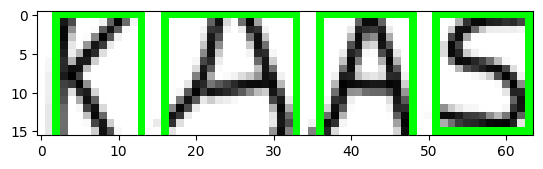

Word: kaas


In [11]:
word_img_path = 'data/word.png'

image = cv2.imread(word_img_path)

gray = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2GRAY)

ret, im = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

contours, hierarchy = cv2.findContours(
    im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(f"Number of contours found: {len(contours)}")

letter_boxes = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > 1 and h > 1:
        letter_boxes.append((x, y, w, h))

letter_boxes = sorted(letter_boxes, key=lambda x: x[0])

image_with_boxes = image.copy()

image_with_boxes = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

predictions = []
word = ""

for i, letter_boxes in enumerate(letter_boxes):
    x, y, w, h = letter_boxes
    letter_image = im[y:y+h, x:x+w]

    letter_image = cv2.bitwise_not(letter_image)

    letter_image = cv2.resize(letter_image, (16, 16))

    letter_image = np.reshape(letter_image, (1, 16, 16, 1))

    prediction = model(torch.from_numpy(letter_image).float())

    predicted_label = torch.argmax(prediction, 1)

    cv2.rectangle(image_with_boxes, (x, y), (x+w, y+h), (0, 255, 0), 1)

    print(categories[predicted_label[0]])
    word += categories[predicted_label[0]]

plt.imshow(image_with_boxes)
plt.show()

print(f"Word: {word}")

In [12]:
# Letter prediction from drawn letter

import cv2
import numpy as np

image = np.ones((256, 256, 3), dtype=np.uint8) * 255

def draw(event, x, y, flags, param):
    if event == cv2.EVENT_MOUSEMOVE and flags == cv2.EVENT_FLAG_LBUTTON:
        cv2.circle(image, (x, y), 10, (0, 0, 0), -1)

cv2.namedWindow('Draw a letter')
cv2.setMouseCallback('Draw a letter', draw)

while True:
    cv2.imshow('Draw a letter', image)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

coords = cv2.findNonZero(gray)
x, y, w, h = cv2.boundingRect(coords)

gray = gray[y:y+h, x:x+w]
gray = cv2.resize(gray, (16, 16))
gray = np.reshape(gray, (1, 16, 16, 1))

prediction = model(torch.from_numpy(gray).float())

predicted_label = torch.argmax(prediction, 1)

print(f"Predicted letter: {categories[predicted_label[0]]}")

Predicted letter: c


In [13]:
# Dataset generation

def add_image_to_dataset(img, label):
    letter = label
    number = 0

    if not os.path.isdir(f"data/{letter}"):
        os.makedirs(f"data/{letter}")

    while os.path.isfile(f"data/{letter}/{number}.png"):
        number += 1

    cv2.imwrite(f"data/{letter}/{number}.png", img)

    print(f"Added image to dataset: {letter}/{number}.png")


def draw_letter():
    image = np.ones((256, 256, 3), dtype=np.uint8) * 255

    def draw(event, x, y, flags, param):
        if event == cv2.EVENT_MOUSEMOVE and flags == cv2.EVENT_FLAG_LBUTTON:
            cv2.circle(image, (x, y), 10, (0, 0, 0), -1)

    cv2.namedWindow('Draw a letter')
    cv2.setMouseCallback('Draw a letter', draw)

    while True:
        cv2.imshow('Draw a letter', image)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    coords = cv2.findNonZero(image)
    x, y, w, h = cv2.boundingRect(coords)
    image = image[y:y+h, x:x+w]
    image = cv2.resize(image, (16, 16))

    return image

image = draw_letter()

input_label = input("Enter the label for the image: ")

add_image_to_dataset(image, input_label)

Added image to dataset: p/7.png


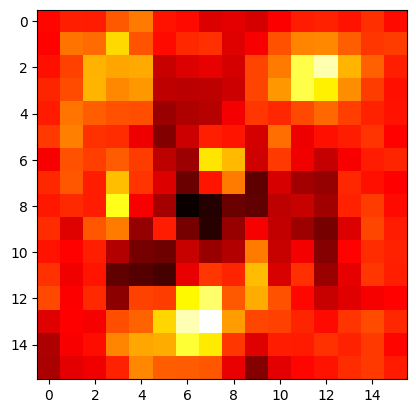

In [14]:
def plot_heatmap_letter(letter):
    # make the model make a heatmap for the letter

    heatmap = np.zeros((16, 16))

    for i in range(16):
        for j in range(16):
            img = np.zeros((16, 16))
            img[i, j] = 1
            img = np.reshape(img, (1, 16, 16, 1))
            prediction = model(torch.from_numpy(img).float())
            heatmap[i, j] = F.softmax(prediction, dim=1).data[0][letter].item()

    plt.imshow(heatmap, cmap='hot', interpolation='nearest')
    plt.show()

plot_heatmap_letter(categories.index('a'))